<a href="https://colab.research.google.com/github/edasaruhan/FTL_Ethiopia_ML1_Gr8/blob/notebook/Rainfall_prediction_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
warnings.filterwarnings("ignore")

In [2]:
# Load train and test datasets
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    print("Train and test datasets loaded successfully.")
    print(f"Train shape: {df_train.shape}")
    print(f"Test shape: {df_test.shape}")
except FileNotFoundError:
    print("Error: 'train.csv' or 'test.csv' not found. Please upload the files to Colab.")
    raise

Train and test datasets loaded successfully.
Train shape: (2190, 13)
Test shape: (730, 12)


In [3]:
# Try to load and preprocess Rainfall.csv
try:
    df_extra = pd.read_csv('Rainfall.csv')
    print("Rainfall.csv loaded successfully.")
    # Preprocess to match train.csv
    df_extra.columns = df_extra.columns.str.replace(' ', '').str.lower()
    df_extra['rainfall'] = df_extra['rainfall'].map({'no': 0, 'yes': 1, 0: 0, 1: 1})
    df_extra['humidity'] = pd.to_numeric(df_extra['humidity'], errors='coerce')
    df_extra['cloud'] = pd.to_numeric(df_extra['cloud'], errors='coerce')
    # Drop rows with NaN in critical columns
    df_extra = df_extra.dropna(subset=['rainfall'])
    # Select common columns (excluding 'id' if not in Rainfall.csv)
    df_train_features = [col for col in df_train.columns if col != 'id']
    common_columns = [col for col in df_train_features if col in df_extra.columns]
    if not common_columns:
        print("Error: No common columns between Rainfall.csv and train.csv. Proceeding with train.csv only.")
    else:
        if len(common_columns) < len(df_train_features):
            missing_cols = [col for col in df_train_features if col not in common_columns]
            print(f"Warning: Rainfall.csv missing columns: {missing_cols}. Using common columns: {common_columns}")
        df_extra = df_extra[common_columns]
        # Ensure train.csv uses the same columns
        df_train_subset = df_train[common_columns]
        # Combine datasets
        df_train = pd.concat([df_train_subset, df_extra], axis=0, ignore_index=True)
        print(f"Combined train shape: {df_train.shape}")
except FileNotFoundError:
    print("Rainfall.csv not found. Proceeding with train.csv only.")
except Exception as e:
    print(f"Error processing Rainfall.csv: {str(e)}. Proceeding with train.csv only.")

Rainfall.csv loaded successfully.
Combined train shape: (2556, 12)


In [4]:
# Drop duplicates from train data
df_train = df_train.drop_duplicates()
print(f"Train shape after dropping duplicates: {df_train.shape}")

Train shape after dropping duplicates: (2556, 12)


In [5]:
# Check for missing values
print("Missing values in train:")
print(df_train.isnull().sum())
print("\nMissing values in test:")
print(df_test.isnull().sum())

Missing values in train:
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        1
rainfall         0
dtype: int64

Missing values in test:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


In [7]:
# Fill missing values with forward fill
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)

# Verify no missing values remain
print("Missing values after filling (train):")
print(df_train.isnull().sum())
print("\nMissing values after filling (test):")
print(df_test.isnull().sum())

Missing values after filling (train):
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

Missing values after filling (test):
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
dtype: int64


In [8]:

# Check class imbalance
print("\nRainfall distribution:")
print(df_train['rainfall'].value_counts(normalize=True))


Rainfall distribution:
rainfall
1    0.742958
0    0.257042
Name: proportion, dtype: float64


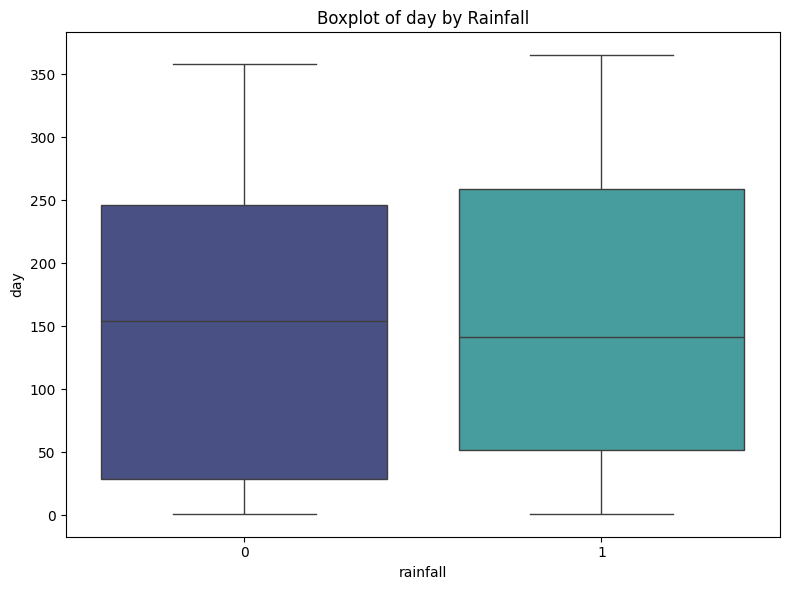

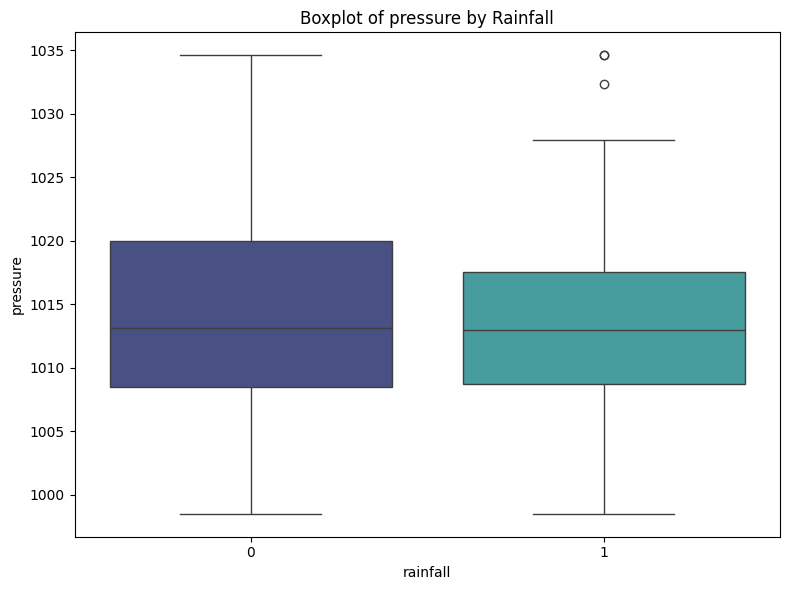

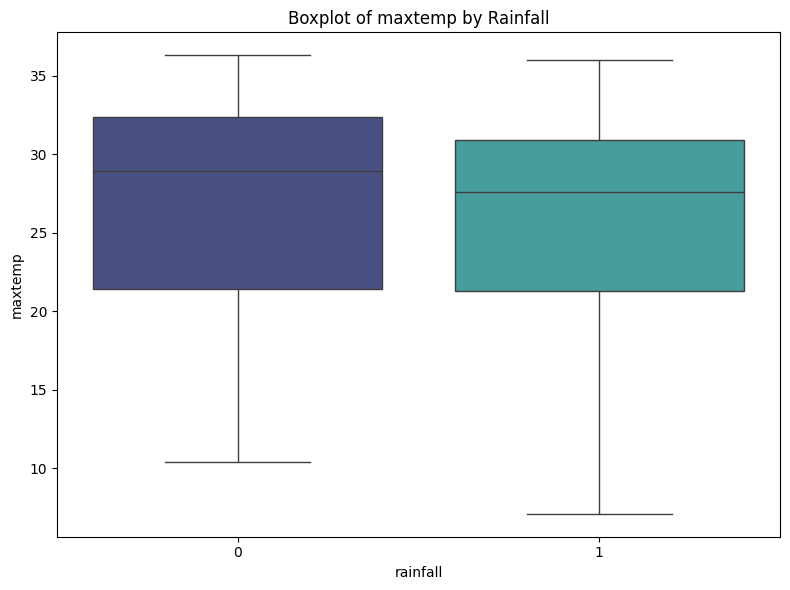

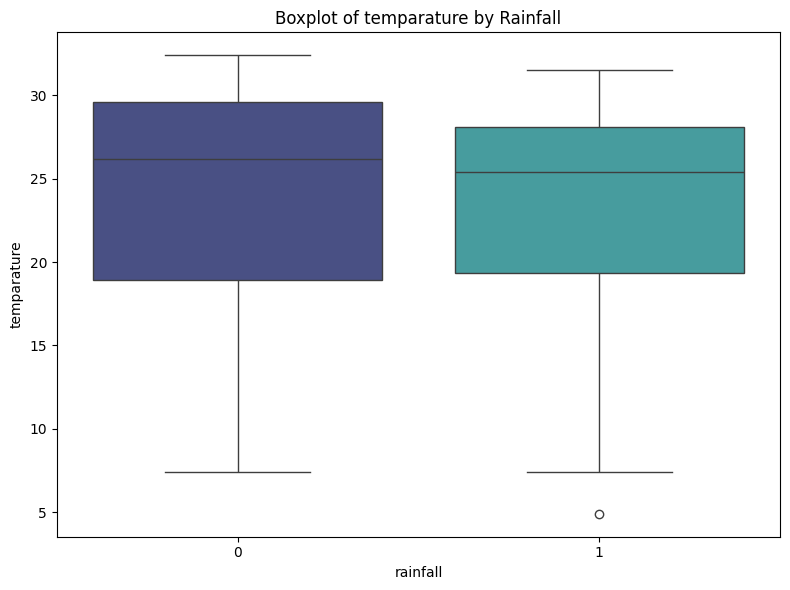

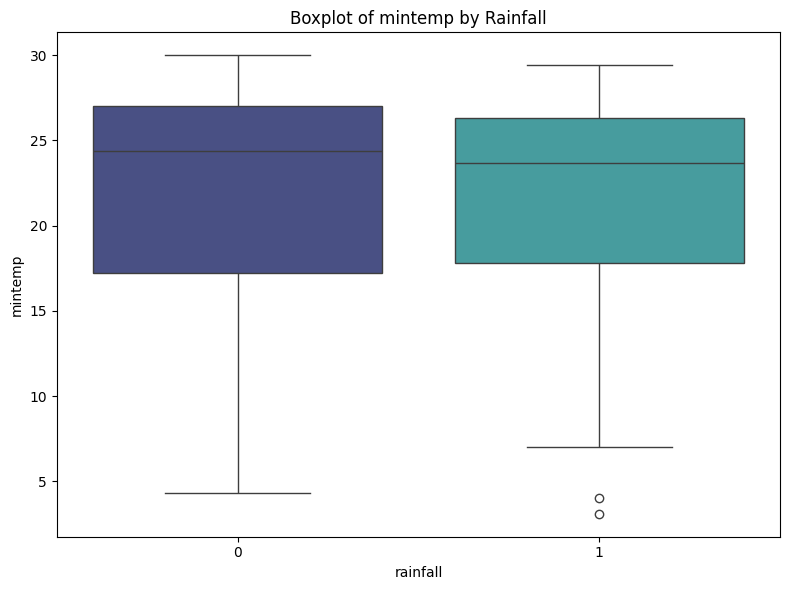

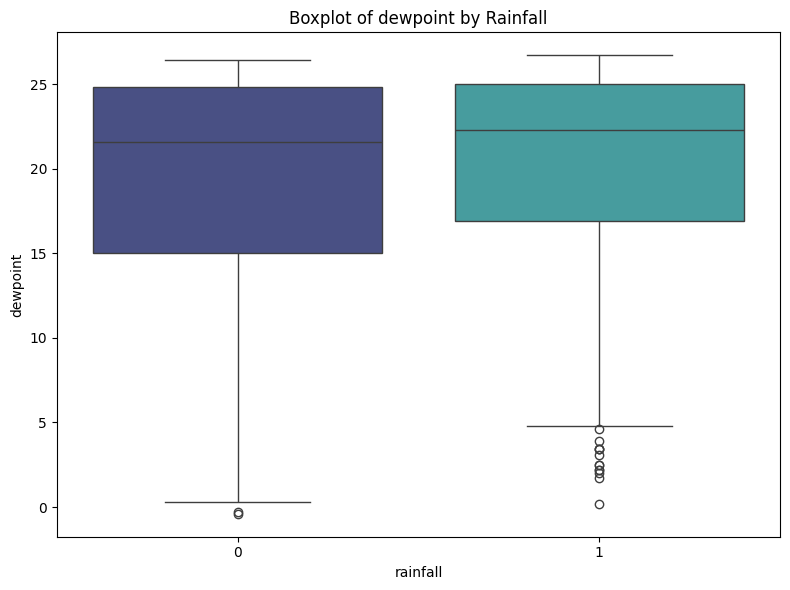

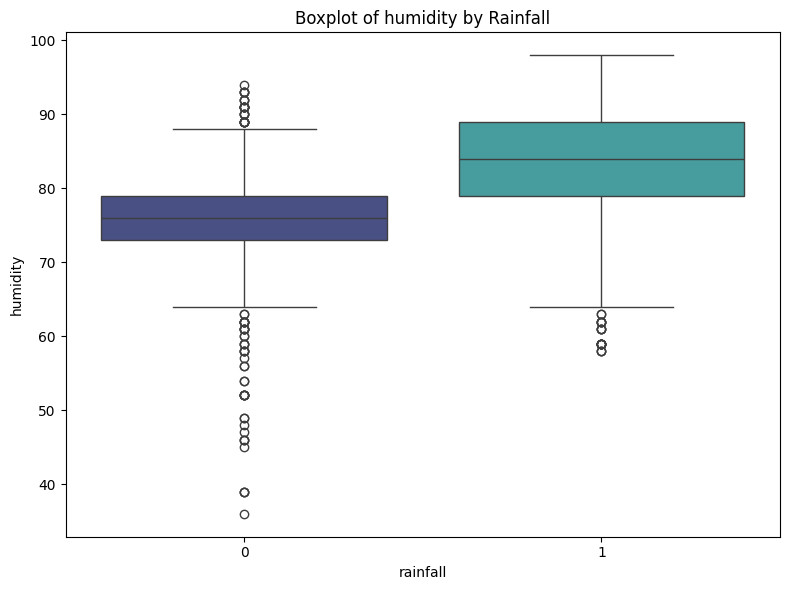

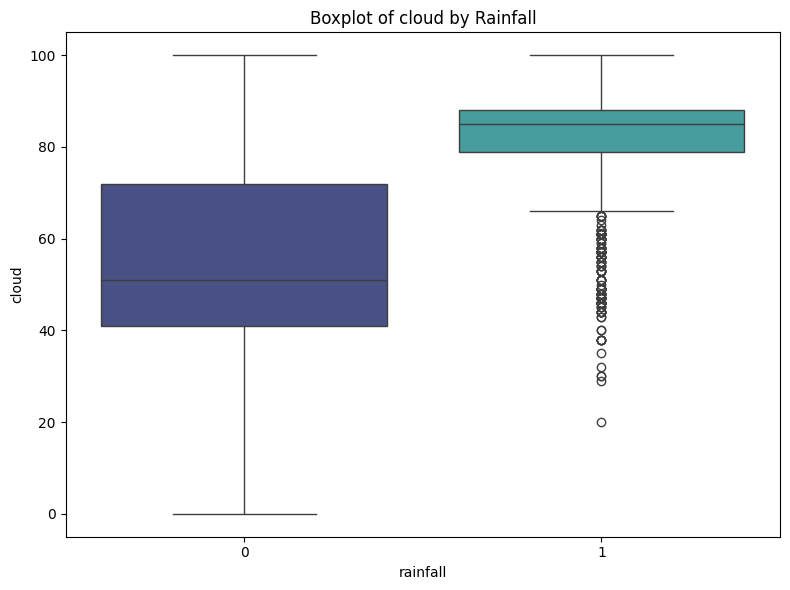

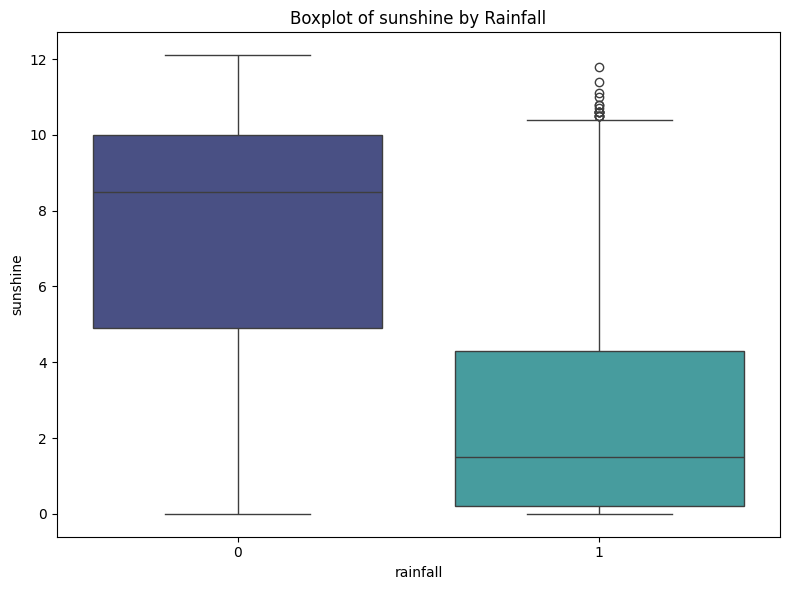

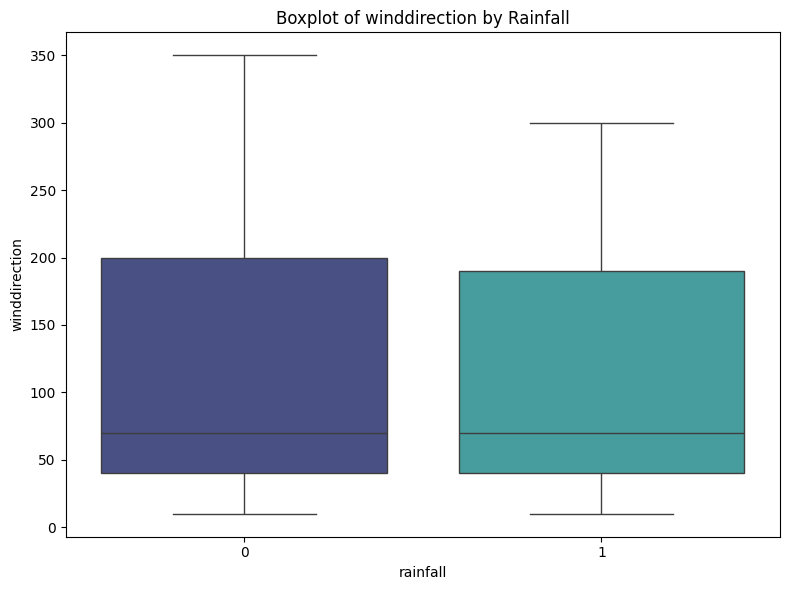

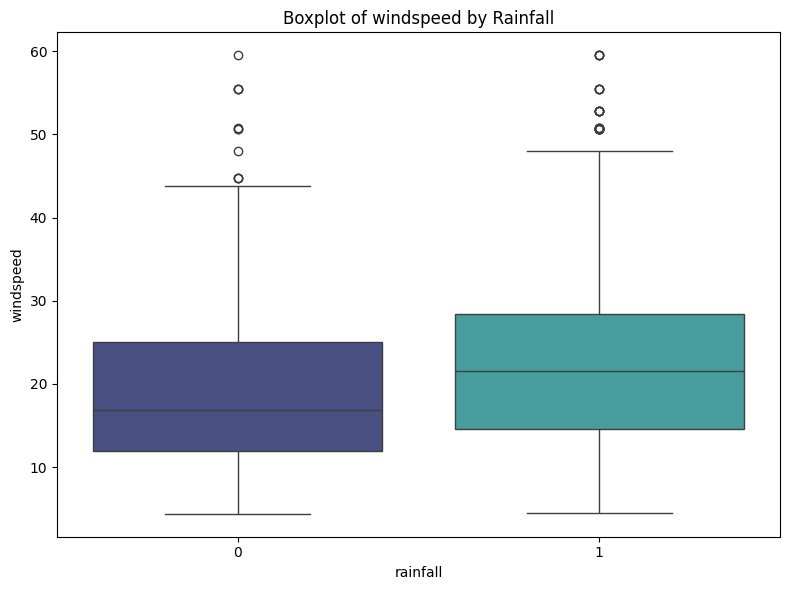

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplots for each feature
for col in df_train.columns[:-1]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_train, y=col, x='rainfall', palette='mako')
    plt.title(f'Boxplot of {col} by Rainfall')
    plt.tight_layout()
    plt.savefig(f'boxplot_{col}.png')
    plt.show()

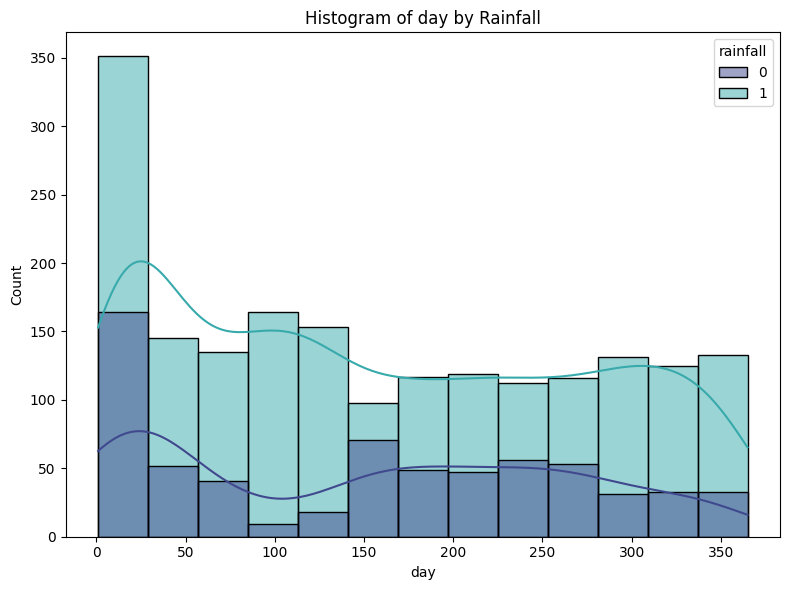

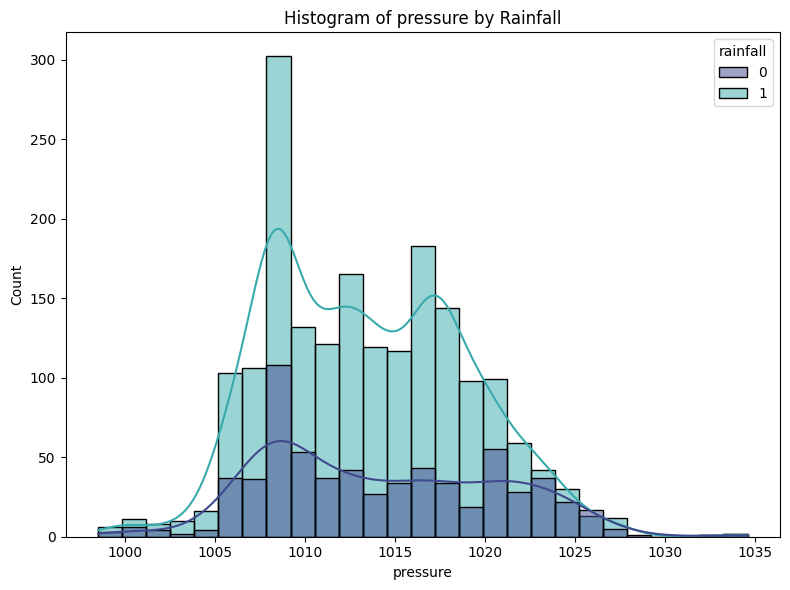

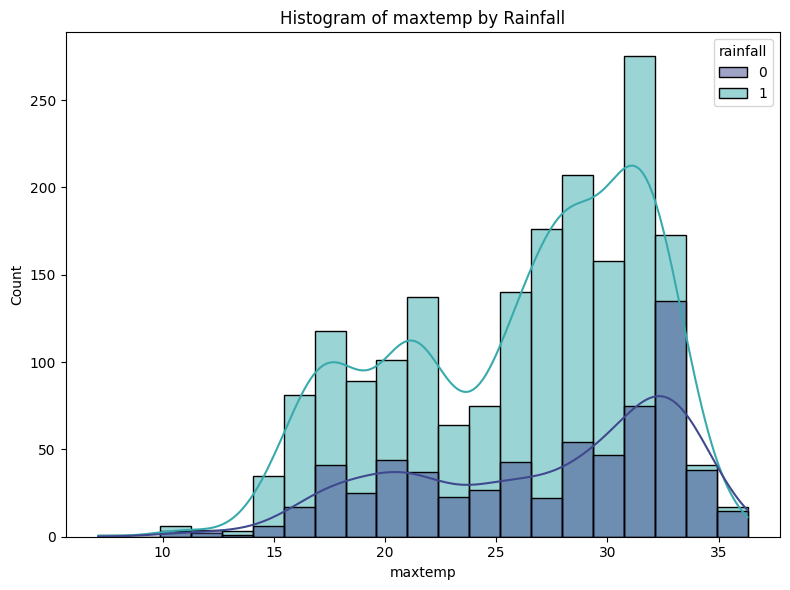

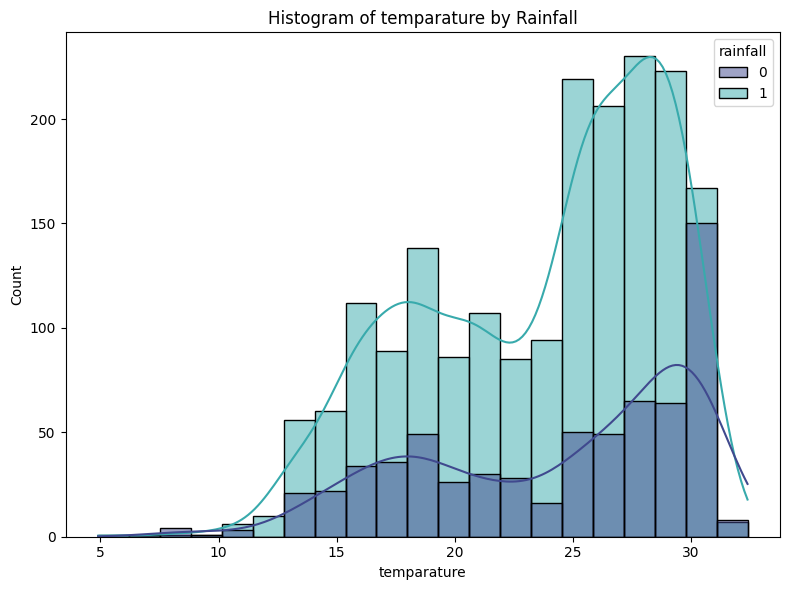

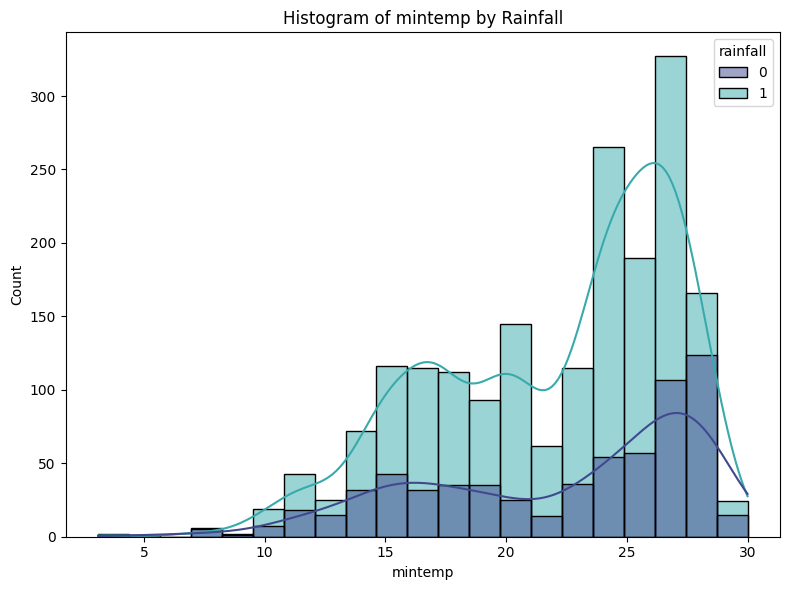

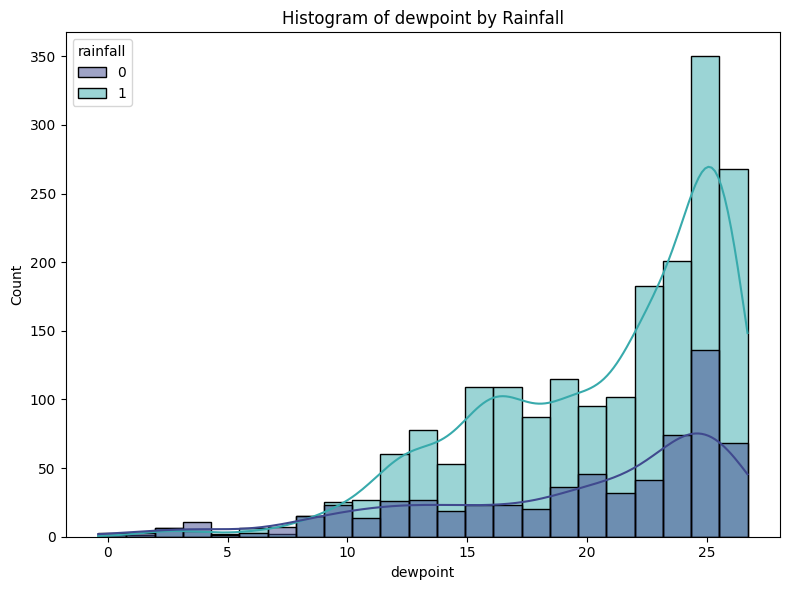

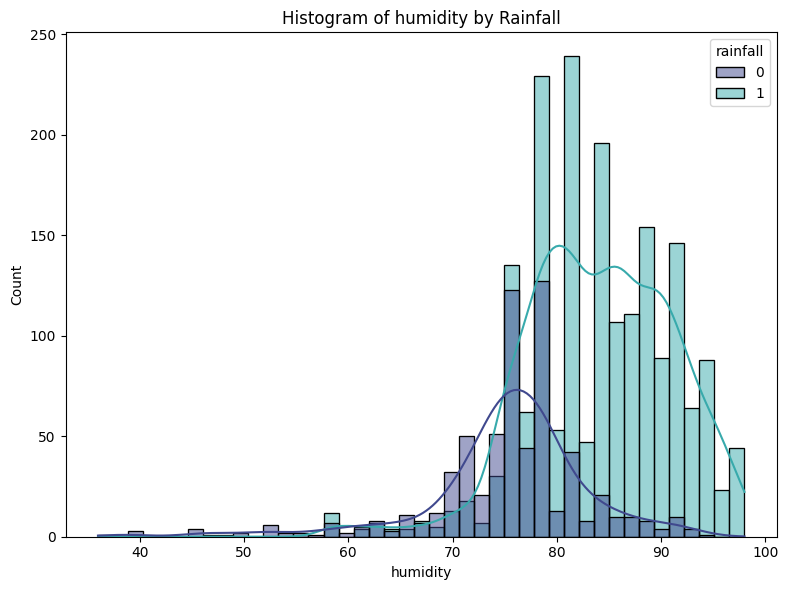

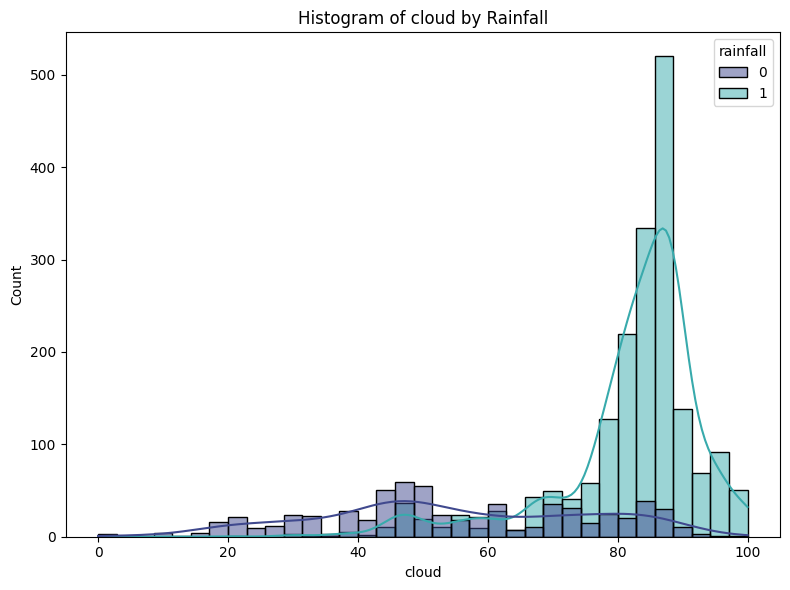

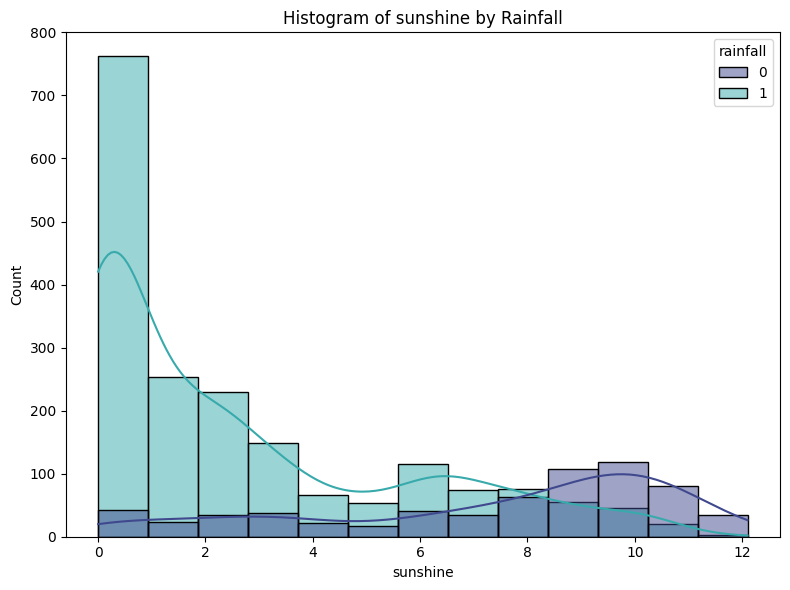

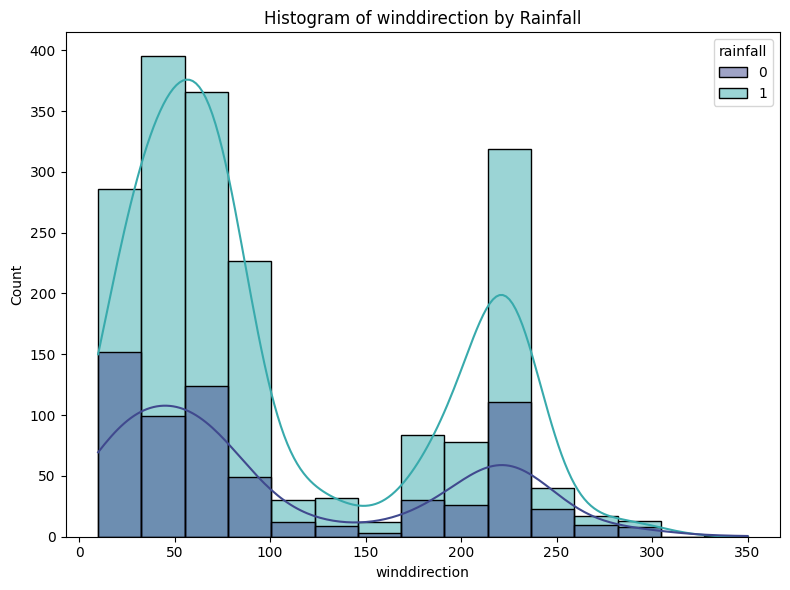

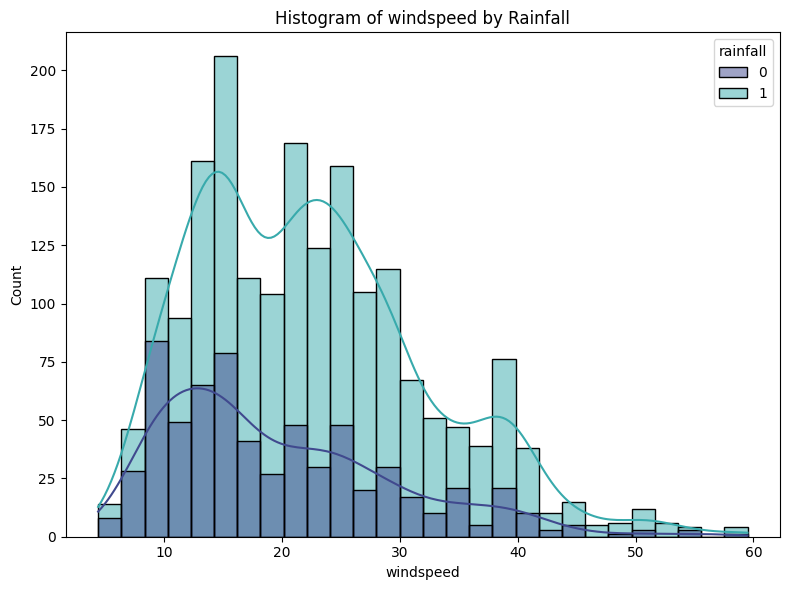

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms for each feature
for col in df_train.columns[:-1]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_train, x=col, hue='rainfall', palette='mako', kde=True)
    plt.title(f'Histogram of {col} by Rainfall')
    plt.tight_layout()
    plt.savefig(f'histogram_{col}.png')
    plt.show()

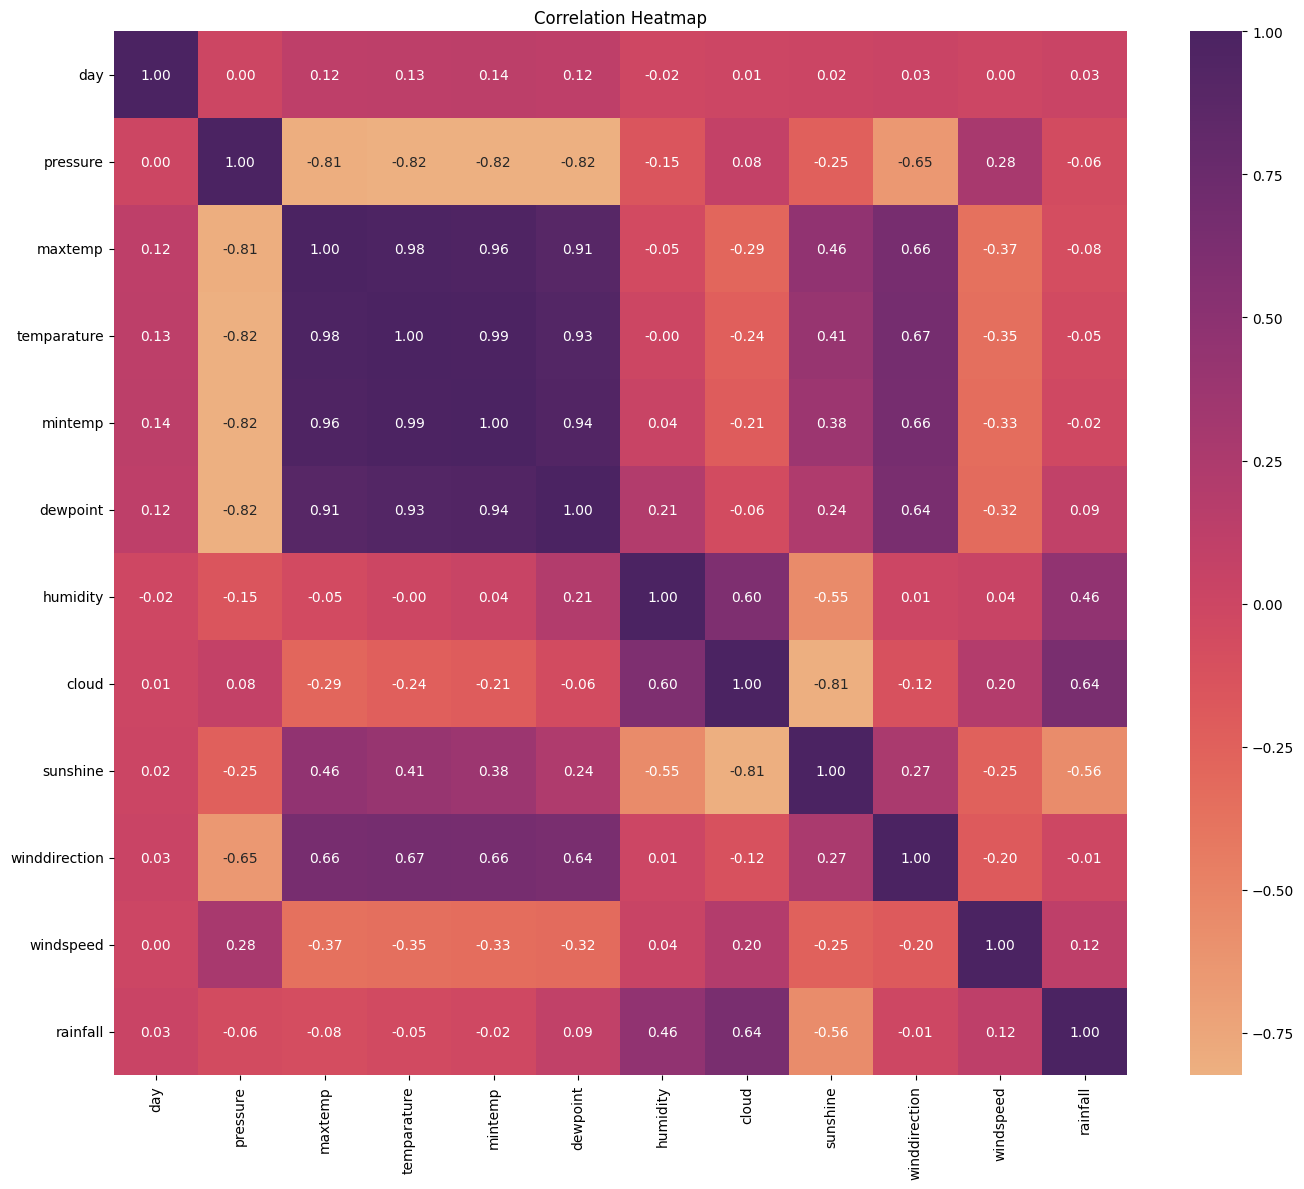

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(data=df_train.corr(), annot=True, cmap='flare', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

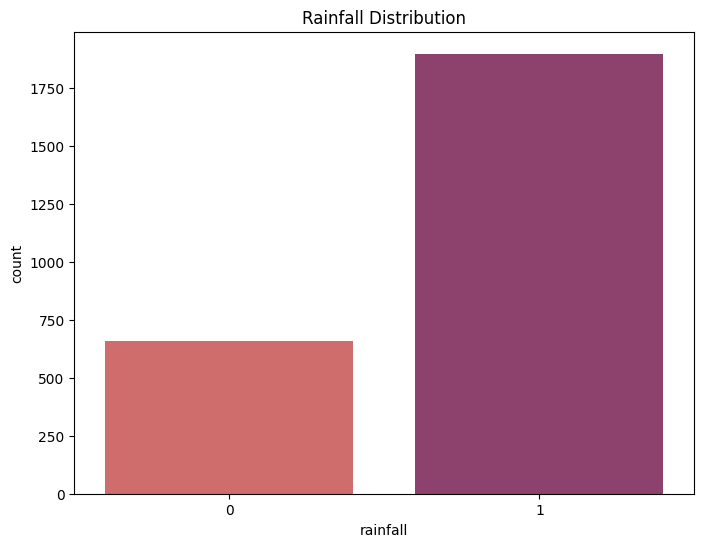

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot for rainfall
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='rainfall', palette='flare')
plt.title('Rainfall Distribution')
plt.savefig('rainfall_distribution.png')
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare features and target
X = df_train.drop(['rainfall'], axis=1)
y = df_train['rainfall']

# Verify test set columns match train (except rainfall and id)
test_columns = set(df_test.columns) - {'id'}
train_columns = set(X.columns)
if test_columns != train_columns:
    print(f"Warning: Test columns {test_columns} do not match train columns {train_columns}")

# Scale features
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.2)
print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Train set shape: (2044, 11), Test set shape: (512, 11)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,657 (72.88 KB)

 Trainable params: 18,145 (70.88 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4358 - loss: 0.6981
Epoch 1: val_loss improved from inf to 0.60347, saving model to best_model_nn.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4795 - loss: 0.6776 - val_accuracy: 0.8411 - val_loss: 0.6035
Epoch 2/100
42/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7642 - loss: 0.5146
Epoch 2: val_loss improved from 0.60347 to 0.50900, saving model to best_model_nn.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7706 - loss: 0.5082 - val_accuracy: 0.8509 - val_loss: 0.5090
Epoch 3/100
47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8190 - loss: 0.4564
Epoch 3: val_loss improved from 0.50900 to 0.44746, saving model to best_model_nn.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8191 - loss: 0.4543 - val_accuracy: 0.8533 - val_loss: 0.4475
Epoch 4/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8160 - loss: 0.4203
Epoch 4: val_loss improved from 0.44746 to 0.44396, sa

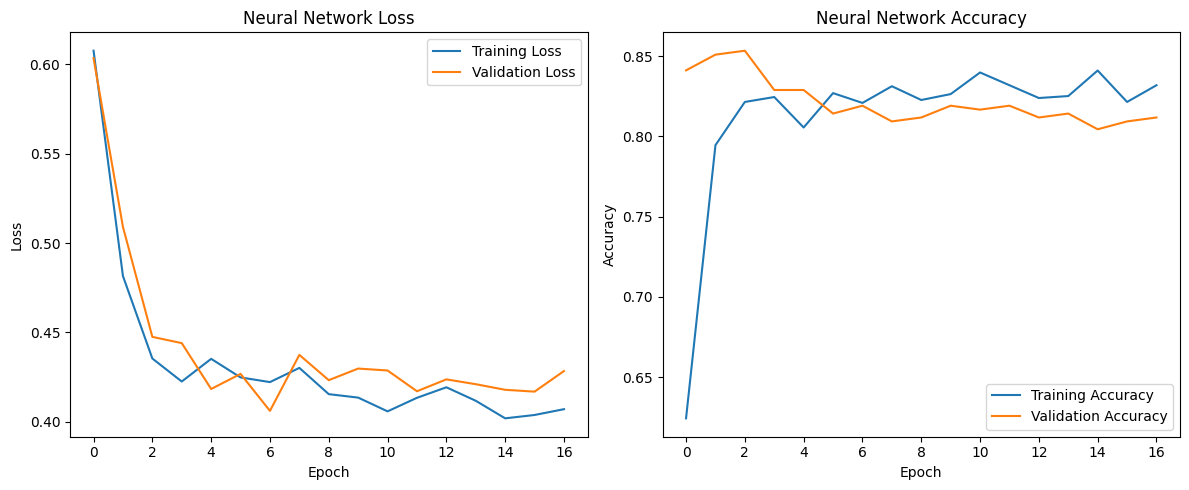

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

# Compute class weights for imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Define model
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Model summary
model_nn.summary()

# Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_nn.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model_nn.fit(X_train, y_train,
                      epochs=100,
                      batch_size=32,
                      validation_split=0.2,
                      callbacks=[checkpoint_callback, early_stopping],
                      class_weight=class_weight_dict,
                      verbose=1)

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('nn_learning_curves.png')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, explained_variance_score
import pandas as pd

# Load best model
model_nn = tf.keras.models.load_model('best_model_nn.keras')

# Predict
y_pred_nn = (model_nn.predict(X_test) > 0.5).astype(int).ravel()
y_pred_proba_nn = model_nn.predict(X_test).ravel()

# Compute metrics
metrics_nn = {
    'Model': 'Neural Network',
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba_nn),
    'MAE': mean_absolute_error(y_test, y_pred_proba_nn),
    'Explained Variance': explained_variance_score(y_test, y_pred_proba_nn)
}

print("\nNeural Network Metrics:")
print(pd.Series(metrics_nn))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Neural Network Metrics:
Model                 Neural Network
Accuracy                      0.8125
ROC AUC                     0.858701
MAE                         0.286508
Explained Variance          0.331329
dtype: object


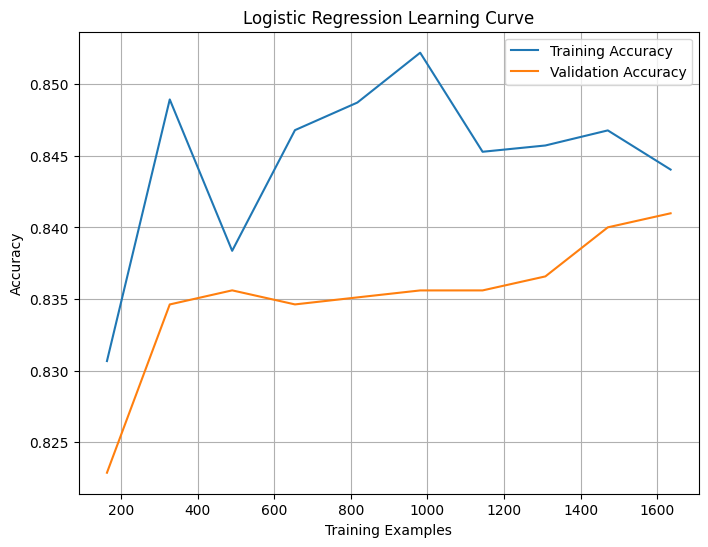

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Train model
model_lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_lr.fit(X_train, y_train)

# Save model
with open('model_lr.pkl', 'wb') as f:
    pickle.dump(model_lr, f)

# Compute learning curves
train_sizes, train_scores, val_scores = learning_curve(
    model_lr, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Accuracy')
plt.title('Logistic Regression Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('lr_learning_curve.png')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, explained_variance_score
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
import pandas as pd

# Load model
with open('model_lr.pkl', 'rb') as f:
    model_lr = pickle.load(f)

# Predict
y_pred_lr = model_lr.predict(X_test)
y_pred_proba_lr = model_lr.predict_proba(X_test)[:, 1]

# Compute McFadden's pseudo-R²
X_const = add_constant(X_test)
logit_model = Logit(y_test, X_const).fit(disp=0)
null_model = Logit(y_test, np.ones((len(y_test), 1))).fit(disp=0)
pseudo_r2 = 1 - (logit_model.llf / null_model.llf)

# Compute metrics
metrics_lr = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba_lr),
    'MAE': mean_absolute_error(y_test, y_pred_proba_lr),
    'Explained Variance': explained_variance_score(y_test, y_pred_proba_lr),
    'Pseudo R²': pseudo_r2
}

print("\nLogistic Regression Metrics:")
print(pd.Series(metrics_lr))


Logistic Regression Metrics:
Model                 Logistic Regression
Accuracy                         0.808594
ROC AUC                          0.865343
MAE                              0.267458
Explained Variance               0.324772
Pseudo R²                        0.346044
dtype: object


Random Forest model trained successfully.
Random Forest model saved to model_rf.pkl.


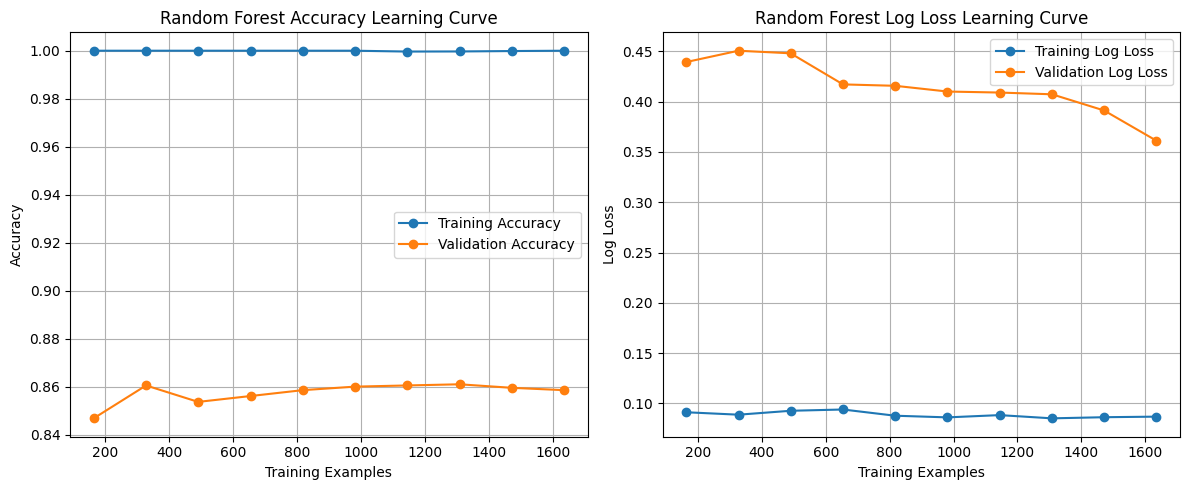

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Train Random Forest model
try:
    model_rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
    model_rf.fit(X_train, y_train)
    print("Random Forest model trained successfully.")
except Exception as e:
    print(f"Error training Random Forest model: {str(e)}")
    raise

# Save model
try:
    with open('model_rf.pkl', 'wb') as f:
        pickle.dump(model_rf, f)
    print("Random Forest model saved to model_rf.pkl.")
except Exception as e:
    print(f"Error saving Random Forest model: {str(e)}")
    raise

# Compute learning curves for accuracy and log loss
train_sizes = np.linspace(0.1, 1.0, 10)
# Accuracy learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    model_rf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=train_sizes, random_state=42
)
# Log loss learning curves
train_sizes_abs, train_scores_loss, val_scores_loss = learning_curve(
    model_rf, X_train, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=train_sizes, random_state=42
)
# Convert negative log loss to positive
train_scores_loss = -train_scores_loss
val_scores_loss = -val_scores_loss

# Plot accuracy and loss learning curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_sizes_abs, train_scores.mean(axis=1), label='Training Accuracy', marker='o')
plt.plot(train_sizes_abs, val_scores.mean(axis=1), label='Validation Accuracy', marker='o')
plt.title('Random Forest Accuracy Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_sizes_abs, train_scores_loss.mean(axis=1), label='Training Log Loss', marker='o')
plt.plot(train_sizes_abs, val_scores_loss.mean(axis=1), label='Validation Log Loss', marker='o')
plt.title('Random Forest Log Loss Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('rf_learning_curves.png')
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, explained_variance_score
import pandas as pd
import pickle

# Load model
with open('model_rf.pkl', 'rb') as f:
    model_rf = pickle.load(f)

# Predict
y_pred_rf = model_rf.predict(X_test)
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Compute metrics
metrics_rf = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba_rf),
    'MAE': mean_absolute_error(y_test, y_pred_proba_rf),
    'Explained Variance': explained_variance_score(y_test, y_pred_proba_rf)
}

print("\nRandom Forest Metrics:")
print(pd.Series(metrics_rf))


Random Forest Metrics:
Model                 Random Forest
Accuracy                   0.847656
ROC AUC                    0.852869
MAE                        0.221719
Explained Variance         0.339063
dtype: object


XGBoost model trained successfully.
XGBoost model saved to model_xgb.pkl.


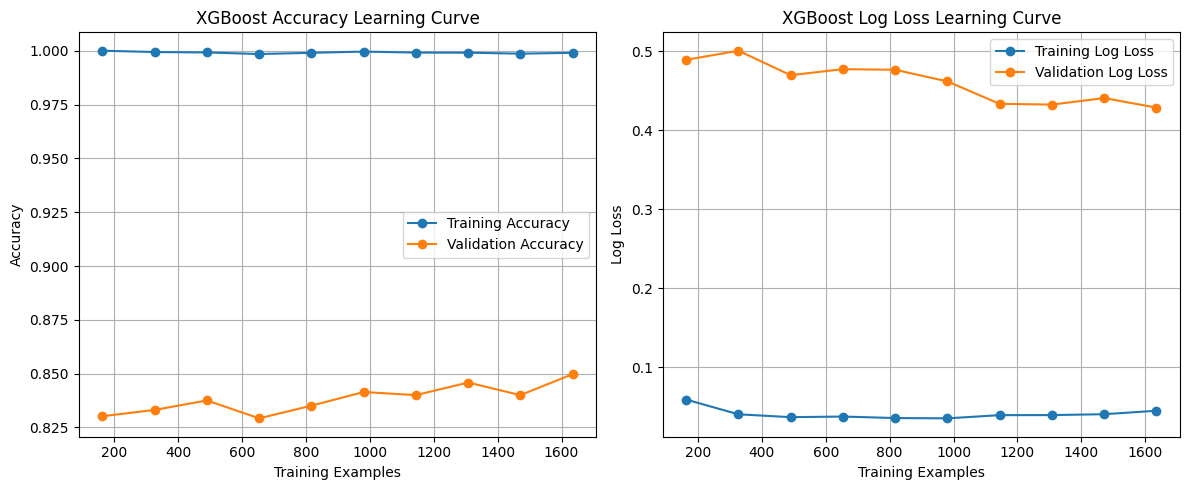

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Train XGBoost model
try:
    model_xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
    model_xgb.fit(X_train, y_train)
    print("XGBoost model trained successfully.")
except Exception as e:
    print(f"Error training XGBoost model: {str(e)}")
    raise

# Save model
try:
    with open('model_xgb.pkl', 'wb') as f:
        pickle.dump(model_xgb, f)
    print("XGBoost model saved to model_xgb.pkl.")
except Exception as e:
    print(f"Error saving XGBoost model: {str(e)}")
    raise

# Compute learning curves for accuracy and log loss
train_sizes = np.linspace(0.1, 1.0, 10)
# Accuracy learning curves
train_sizes_abs, train_scores, val_scores = learning_curve(
    model_xgb, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=train_sizes, random_state=42
)
# Log loss learning curves
train_sizes_abs, train_scores_loss, val_scores_loss = learning_curve(
    model_xgb, X_train, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=train_sizes, random_state=42
)
# Convert negative log loss to positive
train_scores_loss = -train_scores_loss
val_scores_loss = -val_scores_loss

# Plot accuracy and loss learning curves
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_sizes_abs, train_scores.mean(axis=1), label='Training Accuracy', marker='o')
plt.plot(train_sizes_abs, val_scores.mean(axis=1), label='Validation Accuracy', marker='o')
plt.title('XGBoost Accuracy Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_sizes_abs, train_scores_loss.mean(axis=1), label='Training Log Loss', marker='o')
plt.plot(train_sizes_abs, val_scores_loss.mean(axis=1), label='Validation Log Loss', marker='o')
plt.title('XGBoost Log Loss Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('xgb_learning_curves.png')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, explained_variance_score
import pandas as pd
import pickle

# Load model
with open('model_xgb.pkl', 'rb') as f:
    model_xgb = pickle.load(f)

# Predict
y_pred_xgb = model_xgb.predict(X_test)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Compute metrics
metrics_xgb = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba_xgb),
    'MAE': mean_absolute_error(y_test, y_pred_proba_xgb),
    'Explained Variance': explained_variance_score(y_test, y_pred_proba_xgb)
}

print("\nXGBoost Metrics:")
print(pd.Series(metrics_xgb))


XGBoost Metrics:
Model                  XGBoost
Accuracy                0.8125
ROC AUC               0.840584
MAE                   0.211062
Explained Variance    0.208264
dtype: object


In [24]:
import pandas as pd

# Compile results
results = [metrics_nn, metrics_lr, metrics_rf, metrics_xgb]
results_df = pd.DataFrame(results)

# Display comparison table
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                 Model  Accuracy   ROC AUC       MAE  Explained Variance  \
0       Neural Network  0.812500  0.858701  0.286508            0.331329   
1  Logistic Regression  0.808594  0.865343  0.267458            0.324772   
2        Random Forest  0.847656  0.852869  0.221719            0.339063   
3              XGBoost  0.812500  0.840584  0.211062            0.208264   

   Pseudo R²  
0        NaN  
1   0.346044  
2        NaN  
3        NaN  


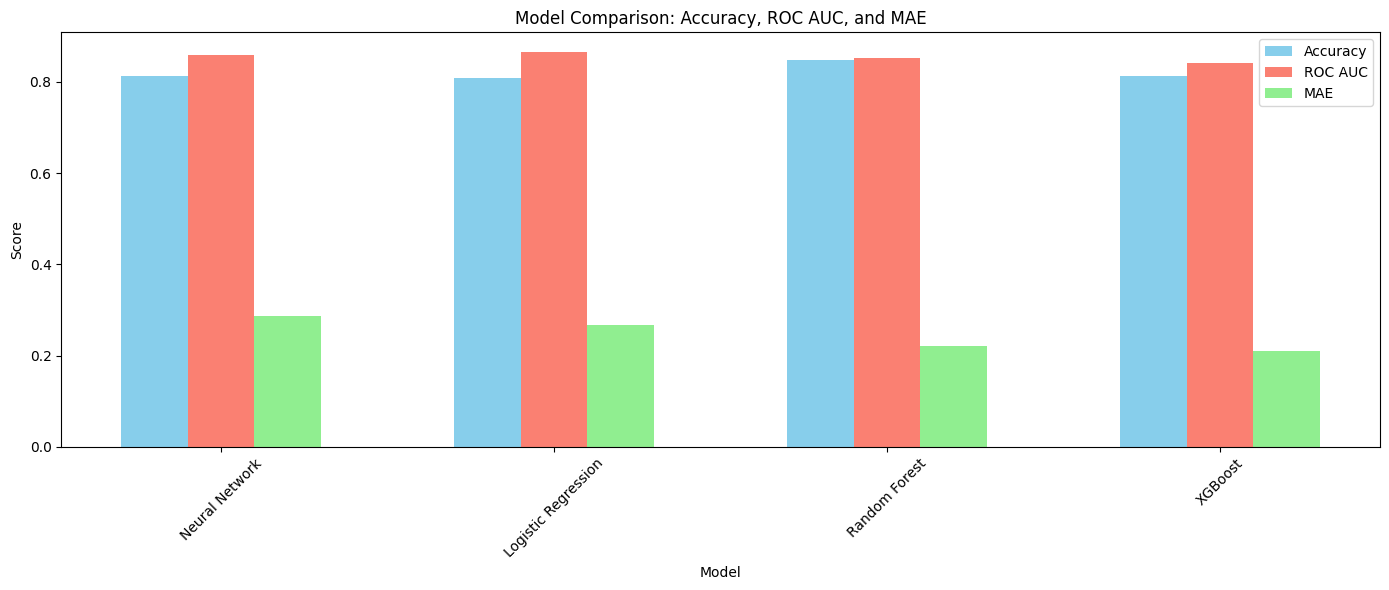

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.2
index = np.arange(len(results_df))

# Accuracy bars
ax.bar(index, results_df['Accuracy'], bar_width, label='Accuracy', color='skyblue')
# ROC AUC bars
ax.bar(index + bar_width, results_df['ROC AUC'], bar_width, label='ROC AUC', color='salmon')
# MAE bars
ax.bar(index + 2 * bar_width, results_df['MAE'], bar_width, label='MAE', color='lightgreen')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Accuracy, ROC AUC, and MAE')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results_df['Model'], rotation=45)
ax.legend()

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)

In [26]:
# Prepare test data
try:
    ID = df_test['id']
    df_test_scaled = sc.transform(df_test.drop(['id'], axis=1))
    print("Test data prepared successfully.")
except KeyError as e:
    print(f"Error: Column {e} not found in test set. Ensure test.csv matches train.csv columns.")
    raise

Test data prepared successfully.


Random Forest model loaded successfully.
Test data and IDs verified successfully.
Predictions generated successfully.

Submission file created: submission.csv

Submission Preview (First 5 Rows):


,id,rainfall
0,2190,1.0000
1,2191,1.0000
2,2192,0.8400
3,2193,0.0500
4,2194,0.0300


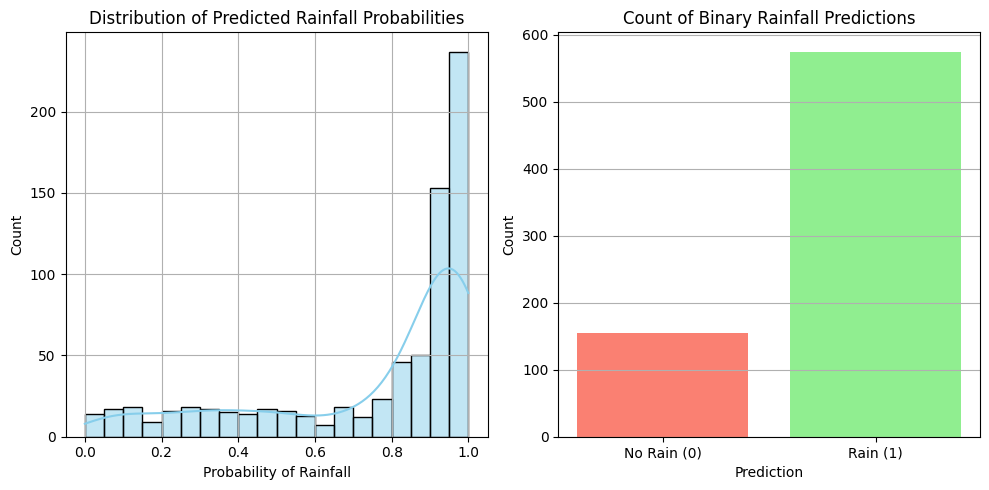

In [27]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load Random Forest model
try:
    with open('model_rf.pkl', 'rb') as f:
        model_rf = pickle.load(f)
    print("Random Forest model loaded successfully.")
except FileNotFoundError:
    print("Error: 'model_rf.pkl' not found. Ensure Cell 17 (Random Forest Model) has been run.")
    raise
except Exception as e:
    print(f"Error loading Random Forest model: {str(e)}")
    raise

# Verify test data and IDs
try:
    if 'df_test_scaled' not in globals() or 'ID' not in globals():
        raise ValueError("Test data ('df_test_scaled') or IDs ('ID') not found. Ensure Cell 23 (Test Data Preparation) has been run.")
    print("Test data and IDs verified successfully.")
except NameError:
    print("Error: Test data or IDs not defined. Please run Cell 23 first.")
    raise

# Generate predictions
try:
    preds = model_rf.predict_proba(df_test_scaled)[:, 1]
    binary_preds = (preds >= 0.5).astype(int)
    print("Predictions generated successfully.")
except Exception as e:
    print(f"Error generating predictions: {str(e)}")
    raise

# Create submission DataFrame
try:
    submission = pd.DataFrame({'id': ID, 'rainfall': preds})
    submission.to_csv('submission.csv', index=False)
    print("\nSubmission file created: submission.csv")
except Exception as e:
    print(f"Error creating submission file: {str(e)}")
    raise

# Display styled submission table
print("\nSubmission Preview (First 5 Rows):")
styled_submission = submission.head().style.set_caption("Submission DataFrame") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ]) \
    .format({'rainfall': '{:.4f}'})
display(styled_submission)

# Plot histogram of predicted probabilities
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(preds, bins=20, kde=True, color='skyblue')
plt.title('Distribution of Predicted Rainfall Probabilities')
plt.xlabel('Probability of Rainfall')
plt.ylabel('Count')
plt.grid(True)

# Plot bar plot of binary predictions
plt.subplot(1, 2, 2)
pred_counts = pd.Series(binary_preds).value_counts().reindex([0, 1], fill_value=0)
pred_labels = ['No Rain (0)', 'Rain (1)']
plt.bar(pred_labels, pred_counts, color=['salmon', 'lightgreen'])
plt.title('Count of Binary Rainfall Predictions')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('submission_predictions.png')
plt.show()

In [28]:
import pandas as pd
import pickle
import requests
from datetime import datetime, timedelta
import numpy as np

# Check if scaler and model are available
try:
    if 'sc' not in globals():
        raise ValueError("Scaler 'sc' not found. Ensure Cell 12 (Data Preparation and Scaling) has been run.")
except NameError:
    print("Error: Scaler 'sc' not found. Please run Cell 12 first.")
    raise

# Load Random Forest model
try:
    with open('model_rf.pkl', 'rb') as f:
        model_rf = pickle.load(f)
    print("Random Forest model loaded successfully.")
except FileNotFoundError:
    print("Error: 'model_rf.pkl' not found. Ensure Cell 17 (Random Forest Model) has been run.")
    raise
except Exception as e:
    print(f"Error loading Random Forest model: {str(e)}")
    raise

# Define feature columns (same as train.csv, excluding 'id' and 'rainfall')
feature_cols = ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
                'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

# Function to get day of year
def get_day_of_year(date_str):
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
        return date.timetuple().tm_yday
    except ValueError:
        print("Error: Date must be in 'YYYY-MM-DD' format (e.g., '2025-05-15').")
        raise

# WeatherAPI key (replace with your actual key)
API_KEY = "42f07f9873614afa9ca180923251206"  # Get from https://www.weatherapi.com

# Prompt user for location and date
country = input("Enter country (e.g., Kenya): ").strip()
city = input("Enter city (e.g., Nairobi): ").strip()
tomorrow = (datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')
date_input = input(f"Enter date for prediction (YYYY-MM-DD, default: {tomorrow}): ").strip() or tomorrow

# Calculate day of year
try:
    day_of_year = get_day_of_year(date_input)
except ValueError:
    raise

# Fetch weather forecast from WeatherAPI
print(f"\nFetching weather forecast for {city}, {country} on {date_input}...")
location = f"{city},{country}"
url = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={location}&dt={date_input}"

try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    forecast = data['forecast']['forecastday'][0]['day']
    hour_data = data['forecast']['forecastday'][0]['hour'][12]  # Noon data for wind, pressure

    # Map API data to model features
    feature_values = []
    for col in feature_cols:
        if col == 'day':
            value = day_of_year
        elif col == 'pressure':
            value = hour_data.get('pressure_mb', 1012.0)  # Default if missing
        elif col == 'maxtemp':
            value = forecast.get('maxtemp_c', 25.0)
        elif col == 'temparature':
            value = forecast.get('avgtemp_c', (forecast['maxtemp_c'] + forecast['mintemp_c']) / 2)
        elif col == 'mintemp':
            value = forecast.get('mintemp_c', 20.0)
        elif col == 'dewpoint':
            # Estimate dewpoint if not provided (approximation)
            temp = forecast.get('avgtemp_c', 22.0)
            hum = forecast.get('avghumidity', 80.0)
            value = temp - ((100 - hum) / 5)  # Simplified formula
        elif col == 'humidity':
            value = forecast.get('avghumidity', 80.0)
        elif col == 'cloud':
            value = hour_data.get('cloud', 50.0)
        elif col == 'sunshine':
            # Estimate sunshine hours (inversely related to cloud cover)
            cloud = hour_data.get('cloud', 50.0)
            value = max(0, 12 * (1 - cloud / 100))  # Max 12 hours
        elif col == 'winddirection':
            value = hour_data.get('wind_degree', 180.0)
        elif col == 'windspeed':
            value = hour_data.get('wind_kph', 10.0)
        feature_values.append(value)

except requests.exceptions.RequestException as e:
    print(f"Error fetching weather data: {str(e)}")
    print("Using example values as fallback (results may be inaccurate).")
    feature_values = [day_of_year, 1012.0, 25.0, 22.0, 20.0, 18.0, 80.0, 50.0, 6.0, 180.0, 10.0]

# Create input DataFrame
input_data = pd.DataFrame([feature_values], columns=feature_cols)

# Scale input data
try:
    input_scaled = sc.transform(input_data)
except Exception as e:
    print(f"Error scaling input data: {str(e)}")
    raise

# Predict rainfall
try:
    probability = model_rf.predict_proba(input_scaled)[0, 1]
    prediction = 1 if probability >= 0.5 else 0
    prediction_label = "Rain" if prediction == 1 else "No Rain"
    print(f"\nRainfall Prediction for {city}, {country} on {date_input}:")
    print(f"Probability of rain: {probability:.2%}")
    print(f"Predicted outcome: {prediction_label}")
except Exception as e:
    print(f"Error making prediction: {str(e)}")
    raise

# Save prediction
try:
    prediction_df = pd.DataFrame({
        'Date': [date_input],
        'Country': [country],
        'City': [city],
        'Probability': [probability],
        'Prediction': [prediction_label]
    })
    prediction_df.to_csv('rainfall_prediction.csv', index=False)
    print("\nPrediction saved to rainfall_prediction.csv")
except Exception as e:
    print(f"Error saving prediction: {str(e)}")
    raise

Random Forest model loaded successfully.
Enter country (e.g., Kenya): uganda
Enter city (e.g., Nairobi): kampala
Enter date for prediction (YYYY-MM-DD, default: 2025-06-14): 2025-06-14

Fetching weather forecast for kampala, uganda on 2025-06-14...

Rainfall Prediction for kampala, uganda on 2025-06-14:
Probability of rain: 33.00%
Predicted outcome: No Rain

Prediction saved to rainfall_prediction.csv
